In [8]:
from transformers import ViTImageProcessor

model_name = "google/vit-base-patch16-224"
processor = ViTImageProcessor.from_pretrained(model_name)
processor

ViTImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [1]:
from datasets import load_dataset

dataset = load_dataset("imagefolder", data_dir="transformers_dataset")

Resolving data files:   0%|          | 0/328 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/32 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [2]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 328
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 32
    })
})

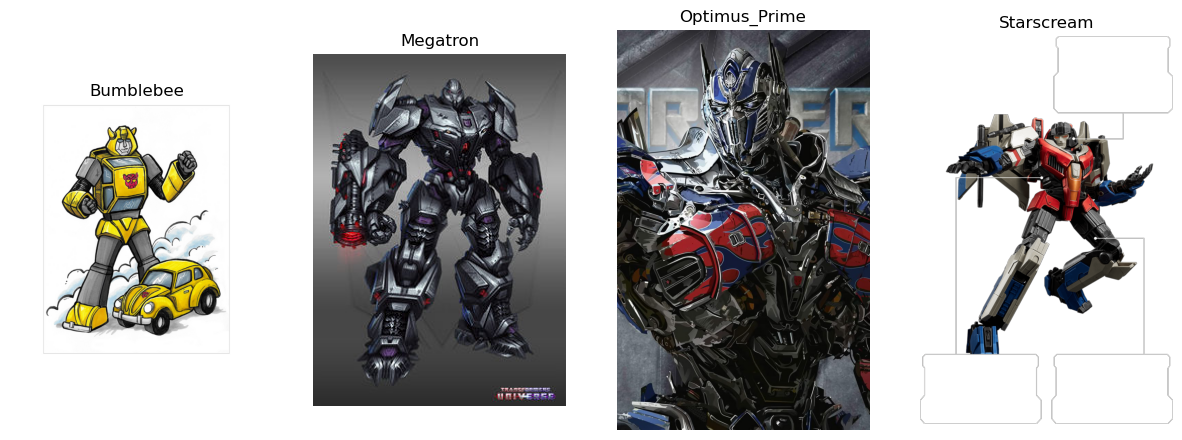

In [13]:
import matplotlib.pyplot as plt

shown_labels = set()

plt.figure(figsize=(15, 10))

train_ds = dataset['train']
# Loop through the dataset and plot the first image of each label
for i, sample in enumerate(train_ds):
    label = train_ds.features["label"].names[sample["label"]]
    if label not in shown_labels:
        plt.subplot(1, len(train_ds.features["label"].names), len(shown_labels) + 1)
        plt.imshow(sample["image"])
        plt.title(label)
        plt.axis("off")
        shown_labels.add(label)
        if len(shown_labels) == len(train_ds.features["label"].names):
            break

plt.show()

In [4]:
train_ds = dataset['train']

# Split the training data into train and validation set
train_val_split = train_ds.train_test_split(test_size=0.1)

# Combine the splits into a new DatasetDict
final_dataset = {
    'train': train_val_split['train'],
    'val': train_val_split['test'],  
    'test': dataset['test']
}

final_dataset

{'train': Dataset({
     features: ['image', 'label'],
     num_rows: 295
 }),
 'val': Dataset({
     features: ['image', 'label'],
     num_rows: 33
 }),
 'test': Dataset({
     features: ['image', 'label'],
     num_rows: 32
 })}

In [5]:
train_ds = final_dataset["train"]
val_ds = final_dataset["val"]
test_ds = final_dataset["test"]

In [6]:
id_to_label = {id: label for id, label in enumerate(train_ds.features["label"].names)}
label_to_id = {label: id for id, label in id_to_label.items()}
id_to_label
label_to_id

{'Bumblebee': 0, 'Megatron': 1, 'Optimus_Prime': 2, 'Starscream': 3}

In [9]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    ToTensor,
    Resize,
)

# Get configurations from ViT processor
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

# Normalizes the image pixels by subtracting the mean and dividing by the std from the pretrained model configurations
normalize = Normalize(mean=image_mean, std=image_std)

# Compose: Combines a series of image transformations into one pipeline.
train_transforms = Compose(
    [
        RandomResizedCrop(size),
        RandomHorizontalFlip(),
        ToTensor(),
        normalize,
    ]
)
val_transforms = Compose(
    [
        Resize(size),
        CenterCrop(size),
        ToTensor(),
        normalize,
    ]
)
test_transforms = Compose(
    [
        Resize(size),
        CenterCrop(size),
        ToTensor(),
        normalize,
    ]
)

In [10]:
def apply_train_transforms(examples):
    examples["pixel_values"] = [train_transforms(image.convert("RGB")) for image in examples["image"]]
    return examples


def apply_val_transforms(examples):
    examples["pixel_values"] = [val_transforms(image.convert("RGB")) for image in examples["image"]]
    return examples


def apply_test_transforms(examples):
    examples["pixel_values"] = [val_transforms(image.convert("RGB")) for image in examples["image"]]
    return examples

train_ds.set_transform(apply_train_transforms)
val_ds.set_transform(apply_val_transforms)
test_ds.set_transform(apply_test_transforms)


In [11]:
import torch
from torch.utils.data import DataLoader


def collate_fn(examples):
    # Stacks the pixel values of all examples into a single tensor and collects labels into a tensor
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

# Create a DataLoader for the training dataset, with custom collation and a batch size of 4
train_dl = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)

In [12]:
from transformers import ViTForImageClassification

labels  = dataset['train'].features['label'].names

model = ViTForImageClassification.from_pretrained(
    model_name, 
    num_labels = len(labels),
    id2label=id_to_label, 
    label2id=label_to_id, 
    ignore_mismatched_sizes=True
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
from transformers import TrainingArguments, Trainer
import numpy as np

train_args = TrainingArguments(
    output_dir="output-models",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=2,
  fp16=True,
  save_steps=10,
  eval_steps=10,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

/nas/longleaf/home/zhangben/.local/lib/python3.10/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [14]:
trainer = Trainer(
    model,
    train_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    tokenizer=processor,
)
trainer.train()

/tmp/ipykernel_2422640/102844377.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Step,Training Loss,Validation Loss
10,1.228900,0.758029
20,0.617800,0.435750
30,0.405500,0.293590


/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


TrainOutput(global_step=38, training_loss=0.6464728493439523, metrics={'train_runtime': 41.4715, 'train_samples_per_second': 14.227, 'train_steps_per_second': 0.916, 'total_flos': 4.572109342531584e+16, 'train_loss': 0.6464728493439523, 'epoch': 2.0})

In [15]:
outputs = trainer.predict(test_ds)
print(outputs.metrics)

{'test_loss': 0.6926102638244629, 'test_runtime': 0.4892, 'test_samples_per_second': 65.408, 'test_steps_per_second': 8.176}


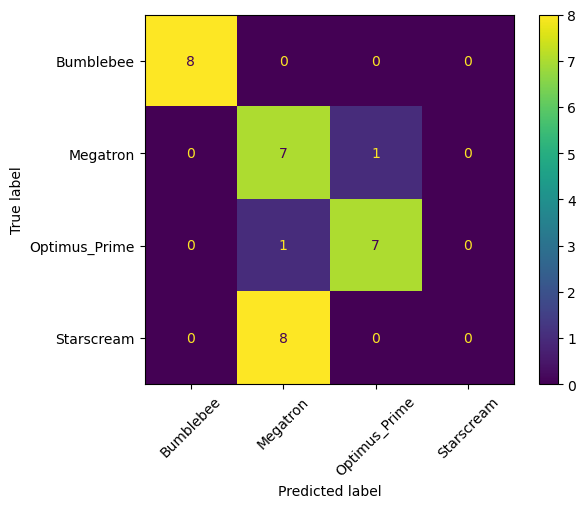

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_ds.features["label"].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)